In [1]:
from json import dump
from random import sample

import matplotlib.pyplot as plt
from numpy import where
from pandas import DataFrame, concat, read_csv
from sklearn.metrics import (
    accuracy_score,
    auc,
    f1_score,
    matthews_corrcoef,
    precision_recall_curve,
    roc_auc_score,
)
from sklearn.svm import OneClassSVM

RESULTS: dict[str, dict[float, dict[str, float]]] = {
    "Grid Search": {},
    "Random Search": {},
    "Bayesian Optimization": {},
}

In [2]:
X_train = read_csv("../data/PAMAP2/x_train_data.csv")
X_test = read_csv("../data/PAMAP2/x_test_data.csv")
y_train = read_csv("../data/PAMAP2/y_train_data.csv")
y_test = read_csv("../data/PAMAP2/y_test_data.csv")

X_train["activity"] = y_train  # First 80% of the data
X_test["activity"] = y_test  # Last 20% of the data

In [3]:
def filter_train_test(data: DataFrame) -> tuple[list, DataFrame, DataFrame]:
    classes: list[int] = [
        num for num in sample(X_train["activity"].value_counts().index.to_list(), 6)
    ]
    classes.sort()
    return (
        classes,
        data[data["activity"].isin(classes)],
        data[~data["activity"].isin(classes)],
    )

In [4]:
def train_ocsvm_with_pollution(
    train: DataFrame, test: DataFrame, model: OneClassSVM, percent: float
) -> dict[str, float]:
    novelty = concat([test, train.sample(n=int(percent * len(train)), random_state=42)])
    preds = where(model.predict(novelty.drop(columns=["isNovelty"])) == -1, True, False)
    precision, recall, _ = precision_recall_curve(novelty["isNovelty"], preds)

    return {
        "f1": float(f1_score(novelty["isNovelty"], preds)),
        "mcc": float(matthews_corrcoef(novelty["isNovelty"], preds)),
        "acc": float(accuracy_score(novelty["isNovelty"], preds)),
        "pr_auc": float(auc(recall, precision)),
        "roc_auc": float(roc_auc_score(novelty["isNovelty"], preds)),
    }

In [ ]:
classes, training, testing = filter_train_test(concat([X_train, X_test]))
training.loc[:, "isNovelty"], testing.loc[:, "isNovelty"] = False, True

print(f"Training with: {classes}")

oc_svm_trad = OneClassSVM(kernel="rbf", nu=0.01, gamma=0.01).fit(
    training.drop(columns=["isNovelty"])
)
oc_svm_beyes = OneClassSVM(
    kernel="rbf", nu=0.016972678234102926, gamma=0.00010145920160011348
).fit(training.drop(columns=["isNovelty"]))

for pollution in [0.2, 0.4, 0.75, 0.9]:
    print(f"Results for Grid & Random Search:\nwith {pollution * 100}% pollution")
    RESULTS["Grid & Random Search"].update(
        result := {
            pollution: train_ocsvm_with_pollution(
                training, testing, oc_svm_trad, pollution
            )
        }
    )
    print(f"{result}", "=" * 40)
    print(f"Results for Bayesian Optimization:\nwith {pollution * 100}% pollution")
    RESULTS["Bayesian Optimization"].update(
        result := {
            pollution: train_ocsvm_with_pollution(
                training, testing, oc_svm_beyes, pollution
            )
        }
    )
    print(f"{result}", "=" * 40)

Training with: [2, 4, 5, 13, 16, 17]


In [11]:
with open("../reports/result_all.json", "w") as fp:
    dump(RESULTS, fp)

In [2]:
from pandas import DataFrame

df_trad = DataFrame(
    {
        "0.2": {
            "f1": 0.9591558883594282,
            "mcc": 0.692234795735105,
            "acc": 0.9276672694394213,
            "pr_auc": 0.960758665794637,
            "roc_auc": 0.76,
        },
        "0.4": {
            "f1": 0.921289095394248,
            "mcc": 0.6654563544100663,
            "acc": 0.8738838842811223,
            "pr_auc": 0.9270324381911025,
            "roc_auc": 0.7592497197054635,
        },
        "0.75": {
            "f1": 0.8612190276858107,
            "mcc": 0.6244699712132372,
            "acc": 0.8064788987034455,
            "pr_auc": 0.8781319887772944,
            "roc_auc": 0.7578218429813504,
        },
        "0.9": {
            "f1": 0.8377045414622941,
            "mcc": 0.6090816329702567,
            "acc": 0.7845521892769377,
            "pr_auc": 0.8603664349322235,
            "roc_auc": 0.7573633388549957,
        },
    }
)
df_bayes = DataFrame(
    {
        "0.2": {
            "f1": 0.9359467135052523,
            "mcc": 0.7161845231110786,
            "acc": 0.897419036659543,
            "pr_auc": 0.9893265461300753,
            "roc_auc": 0.9321560315719294,
        },
        "0.4": {
            "f1": 0.9344546044615507,
            "mcc": 0.800453878476828,
            "acc": 0.9086312948926545,
            "pr_auc": 0.981100133783426,
            "roc_auc": 0.9324441761919731,
        },
        "0.75": {
            "f1": 0.9318389571161718,
            "mcc": 0.8497711328403695,
            "acc": 0.9224843741928819,
            "pr_auc": 0.9700660281782861,
            "roc_auc": 0.9325544313556681,
        },
        "0.9": {
            "f1": 0.9307186725568366,
            "mcc": 0.8596970792064911,
            "acc": 0.9269523519106472,
            "pr_auc": 0.9661989062093939,
            "roc_auc": 0.9325705223240631,
        },
    },
)

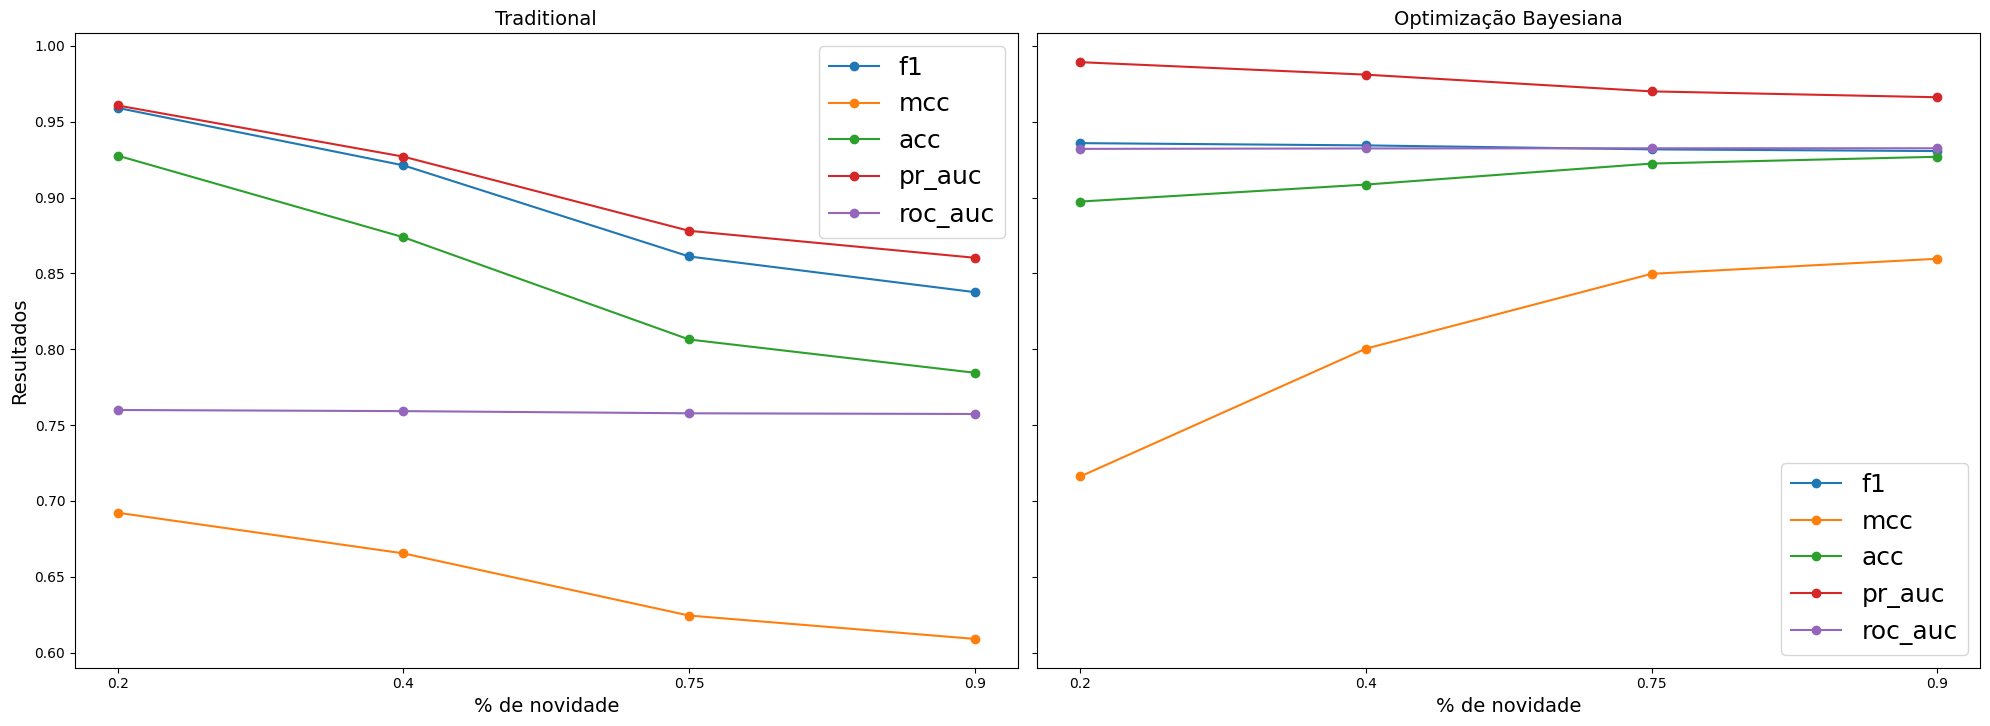

In [22]:
df_trad = df_trad.transpose()
df_bayes = df_bayes.transpose()
fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)

# Plot each technique in its own subplot
for i, (technique_name, df) in enumerate(
    zip(["Traditional", "Optimização Bayesiana"], [df_trad, df_bayes])
):
    for metric in df_trad.columns.tolist():
        axes[i].plot(df_trad.index.tolist(), df[metric], marker="o", label=metric)

    axes[i].set_ylabel("Resultados" if i == 0 else "")
    axes[i].set_xlabel("% de novidade")
    axes[i].set_title(technique_name)
    axes[i].tick_params(axis="x", rotation=0)
    axes[i].legend(loc="best", fontsize=18)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [24]:
df_bayes.transpose().to_clipboard()